# Updating a proofreading table or a list id file

This notebook contains functions and example scripts to update a proofreading table or lists of ids stored in an excel or txt file

Content per section:
<br>A) Updating IDs and presynaptic counts
<br>B) Updating main postsynaptic neurons database (table)
<br>C) Updating a list of IDs from a txt file

In [2]:
import os
import pandas as pd
import numpy as np
import fafbseg
from fafbseg import flywire
from caveclient import CAVEclient
client = CAVEclient('flywire_fafb_production')

C:\Users\smolina\Anaconda3\envs\EM\lib\site-packages\blessed\terminal.py:186: UserWarning: Failed to setupterm(kind='xterm-color'): Could not find terminal xterm-color
  warnings.warn(msg)


## A) Updating IDs and presynaptic counts

### 1. Loading Tm9 input neuron table

In [69]:
# Choose path and file
dataPath = r'D:\Connectomics-Data\FlyWire\Excels\drive-data-sets'
date = '20230524'
fileName = f'All_Tm9_neurons_input_count_ME_R_{date}.xlsx'
fileName = f'Across_OL_Tm9_neurons_input_count_ME_R_{date}.xlsx'
filePath = os.path.join(dataPath,fileName)

In [70]:
#Loading file as DataFrame
df = pd.read_excel(filePath)
df.head()

,presynaptic_ID,counts,count %,postsynaptic_ID,symbol,guess,lab,author,name,FlyWire proofread (Y/N),...,Update_confidence,Updated_counts,duplicates,notes,annotations_link,Working on,optic_lobe_id,column_id,patch_id,hemisphere
0,NaN,NaN,NaN,asdf,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,720575940604585662,24,NaN,720575940637150821,L3,NaN,Mathias Wernet Lab,Gizem Sancer,"Lamina monopolar cell 3, L3, FBbt_00003721 (F...",Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R
2,720575940622052869,17,NaN,720575940637150821,Mi4,NaN,Marion Silies,Lena Lörsch,"Medullary intrinsic neuron 4, Mi4, Mi4_R, FBbt...",Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R
3,720575940630947602,6,NaN,720575940637150821,Tm16,NaN,Marion Silies,Sebastian Mauricio Molina Obando,"Transmedullary neuron 16, Tm16, Tm16_R, FBbt_0...",Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R
4,720575940615003554,4,NaN,720575940637150821,Tm16,NaN,NaN,NaN,"Transmedullary neuron 16, Tm16, Tm16_R, FBbt_0...",Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R


In [71]:
#Dropping the fisrt row ('asdf' was added as a walk-around to set that column values as type str)
if df["postsynaptic_ID"][0] == 'asdf': 
    df = df.iloc[1: , :]
    df.reset_index(inplace=True,drop=True)

#Getting the lists of IDs to update
segmentIDs = df["seg_id"].copy()
pre_IDs = df["presynaptic_ID"].copy()
post_IDs = df["postsynaptic_ID"].copy()


In [72]:
#Replacing the 'INPUTS PROOFREAD' labelled row of the lists for the previous postsynaptic cell ID
for i, id in enumerate(pre_IDs):
    if id == 'INPUTS PROOFREAD':
        segmentIDs[i] = post_IDs[i-1] # The previous postsynaptic cell ID
        pre_IDs[i] = post_IDs[i-1]
        post_IDs[i] = post_IDs[i-1]

### 2. Updating IDs considering our excel file extructure (fast and new version)

In [73]:
#Updating segments 

temp_segmentIDs_df = flywire.update_ids(pre_IDs.tolist(), stop_layer=2, supervoxels=None, timestamp=None, dataset='production', progress=True)
updated_presynaptic_ID_column = temp_segmentIDs_df["new_id"]
confidence_of_update = temp_segmentIDs_df["confidence"]




Updating:   0%|          | 0/5949 [00:00<?, ?it/s]

### 2. Updating IDs considering our excel file extructure (old and slow version) - DO NOT USE -

Updating segments will be slow since we do it in a loop. Please just run this part if you really consider that the IDs in which your are mostly interested in need an update

In [41]:
#Updating segments 
updated_presynaptic_ID_column = []
confidence_of_update = []
count = 1
for id in pre_IDs:
    count =+ 1
    if id == 'INPUTS PROOFREAD':
        updated_presynaptic_ID_column.append('INPUTS PROOFREAD')
        confidence_of_update.append('INPUTS PROOFREAD')
    else:
        temp_segmentIDs_df = flywire.update_ids(id, stop_layer=2, supervoxels=None, timestamp=None, dataset='production', progress=True)
        updated_presynaptic_ID_column.append(str(temp_segmentIDs_df["new_id"][0]))
        confidence_of_update.append(temp_segmentIDs_df["confidence"][0])
    print(f'row: {count} {updated_presynaptic_ID_column[-1]}')
    

row: 1 720575940659388801
row: 1 720575940615238668
row: 1 720575940609780693
row: 1 720575940625018512
row: 1 720575940636607343
row: 1 720575940614237736
row: 1 720575940612520666
row: 1 720575940628312425
row: 1 720575940615007143
row: 1 720575940605245984
row: 1 720575940618464084
row: 1 720575940630882620
row: 1 720575940620975525
row: 1 720575940631339026
row: 1 720575940639559357
row: 1 720575940610613902
row: 1 720575940617694164
row: 1 720575940623818423
row: 1 720575940620503461
row: 1 720575940624241589
row: 1 720575940631976403
row: 1 720575940626440240
row: 1 720575940627168798
row: 1 720575940631116908
row: 1 720575940610400142
row: 1 720575940639005006
row: 1 720575940620233381
row: 1 720575940622763809
row: 1 720575940625488142
row: 1 720575940624124935
row: 1 720575940608879964
row: 1 720575940628041969
row: 1 720575940629569835
row: 1 720575940405923014
row: 1 720575940632726732
row: 1 INPUTS PROOFREAD
row: 1 720575940608700117
row: 1 720575940606285502
row: 1 7205759

row: 1 720575940613411606
row: 1 720575940620459201
row: 1 720575940626459236
row: 1 720575940645022756
row: 1 720575940608590601
row: 1 720575940613079781
row: 1 720575940605202092
row: 1 720575940627304073
row: 1 INPUTS PROOFREAD
row: 1 720575940624985700
row: 1 720575940632418605
row: 1 720575940626719065
row: 1 720575940617817181
row: 1 720575940637788213
row: 1 720575940632171724
row: 1 720575940634841244
row: 1 720575940629804699
row: 1 720575940633028260
row: 1 720575940635065239
row: 1 720575940624134538
row: 1 720575940628101253
row: 1 720575940649696633
row: 1 720575940645336855
row: 1 720575940624882494
row: 1 720575940629563983
row: 1 720575940626440240
row: 1 720575940624020009
row: 1 720575940622589978
row: 1 720575940518216067
row: 1 720575940623889800
row: 1 720575940608824649
row: 1 720575940632050232
row: 1 720575940623001599
row: 1 720575940610459977
row: 1 720575940630016450
row: 1 720575940629188431
row: 1 720575940614572967
row: 1 720575940612711603
row: 1 7205759

row: 1 720575940589625033
row: 1 720575940639068288
row: 1 720575940643709049
row: 1 720575940642783117
row: 1 720575940607947906
row: 1 720575940609138898
row: 1 INPUTS PROOFREAD
row: 1 720575940628389116
row: 1 720575940637944691
row: 1 720575940635257848
row: 1 720575940620734598
row: 1 720575940627487613
row: 1 720575940628005007
row: 1 720575940630462167
row: 1 720575940635720031
row: 1 720575940616958603
row: 1 720575940611009838
row: 1 720575940611395448
row: 1 720575940613137942
row: 1 720575940500899759
row: 1 720575940632088680
row: 1 720575940623625033
row: 1 720575940638570980
row: 1 720575940626709276
row: 1 720575940617791522
row: 1 720575940633581282
row: 1 720575940606214432
row: 1 720575940631225083
row: 1 720575940640332533
row: 1 720575940618303974
row: 1 720575940629797115
row: 1 720575940631727146
row: 1 720575940617750050
row: 1 720575940629236634
row: 1 720575940621536365
row: 1 720575940635196607
row: 1 720575940501023407
row: 1 720575940500901551
row: 1 7205759

row: 1 720575940628312425
row: 1 720575940628101253
row: 1 720575940639559357
row: 1 720575940652504566
row: 1 720575940631730127
row: 1 720575940620503461
row: 1 720575940609780693
row: 1 720575940613079781
row: 1 720575940629221891
row: 1 720575940629045035
row: 1 720575940611349458
row: 1 720575940625011436
row: 1 720575940606168608
row: 1 720575940633557075
row: 1 720575940606398398
row: 1 720575940631976403
row: 1 720575940624124935
row: 1 720575940625377468
row: 1 720575940405926342
row: 1 720575940638533092
row: 1 720575940626657854
row: 1 720575940632757964
row: 1 720575940659388801
row: 1 INPUTS PROOFREAD
row: 1 720575940639479630
row: 1 720575940622458356
row: 1 720575940635666367
row: 1 720575940621399974
row: 1 720575940624361991
row: 1 720575940626743908
row: 1 720575940627172441
row: 1 720575940629780031
row: 1 720575940610603332
row: 1 720575940624304903
row: 1 720575940629763966
row: 1 720575940615435926
row: 1 720575940645386519
row: 1 720575940637271214
row: 1 7205759

row: 1 720575940621489261
row: 1 720575940627172441
row: 1 720575940615435926
row: 1 720575940623858431
row: 1 720575940627010076
row: 1 720575940417471325
row: 1 720575940620793697
row: 1 720575940621804353
row: 1 720575940639479630
row: 1 720575940642142709
row: 1 720575940614431733
row: 1 720575940624361991
row: 1 720575940637271214
row: 1 720575940642774413
row: 1 720575940610603332
row: 1 INPUTS PROOFREAD
row: 1 720575940626170149
row: 1 720575940613070489
row: 1 720575940640543320
row: 1 720575940621354349
row: 1 720575940645912174
row: 1 720575940630918028
row: 1 720575940612895459
row: 1 720575940628762267
row: 1 720575940624881928
row: 1 720575940615100926
row: 1 720575940626498853
row: 1 720575940611046520
row: 1 720575940616022456
row: 1 720575940629563983
row: 1 720575940626440240
row: 1 720575940620169492
row: 1 720575940628786250
row: 1 720575940641531611
row: 1 720575940608590601
row: 1 720575940622019617
row: 1 720575940620656262
row: 1 720575940618261649
row: 1 7205759

In [75]:
### Setting important columns to str
df["presynaptic_ID"] = df["presynaptic_ID"].astype(str)
df["postsynaptic_ID"] = df["postsynaptic_ID"].astype(str)
df["seg_id"] = df["seg_id"].astype(str)

In [76]:
### Updating the dataframe
# Adding the new url column to the data frame
df["Updated_presynaptic_ID"] = updated_presynaptic_ID_column
df["Updated_presynaptic_ID"] = df["Updated_presynaptic_ID"].astype(str) 
df["Update_confidence"] = confidence_of_update

In [77]:
df

,presynaptic_ID,counts,count %,postsynaptic_ID,symbol,guess,lab,author,name,FlyWire proofread (Y/N),...,Updated_counts,duplicates,notes,annotations_link,Working on,optic_lobe_id,column_id,patch_id,hemisphere,Updated_presynaptic_ID
0,720575940604585662,24,NaN,720575940637150821,L3,NaN,Mathias Wernet Lab,Gizem Sancer,"Lamina monopolar cell 3, L3, FBbt_00003721 (F...",Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R,720575940604585662
1,720575940622052869,17,NaN,720575940637150821,Mi4,NaN,Marion Silies,Lena Lörsch,"Medullary intrinsic neuron 4, Mi4, Mi4_R, FBbt...",Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R,720575940622052869
2,720575940630947602,6,NaN,720575940637150821,Tm16,NaN,Marion Silies,Sebastian Mauricio Molina Obando,"Transmedullary neuron 16, Tm16, Tm16_R, FBbt_0...",Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R,720575940630947602
3,720575940615003554,4,NaN,720575940637150821,Tm16,NaN,NaN,NaN,"Transmedullary neuron 16, Tm16, Tm16_R, FBbt_0...",Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R,720575940638965055
4,720575940635652709,4,NaN,720575940637150821,Mi13,NaN,NaN,NaN,"Medullary intrinsic neuron Mi13, Mi13, Mi13_R,...",Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R,720575940635652709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5944,720575940635142810,1,NaN,720575940616066461,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R,720575940635142810
5945,720575940654395297,1,NaN,720575940616066461,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R,720575940654395297
5946,720575940612557717,1,NaN,720575940616066461,Dm12,NaN,"Mala Murthy Lab, Sebastian Seung Lab",Ben Silverman,"Distal medullary amacrine neuron Dm12, Distal ...",Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R,720575940636879215
5947,720575940627020616,1,NaN,720575940616066461,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R,720575940627020616


### 3. Updating counts between pre- and post synaptic partners

Strategy to save time:
1. (Step1) Create a dictionary with postsynaptic neuron's IDs as KEYS and their a input-neuron dataframe as VALUES , and then (step2) create a loop across presynaptic IDs to get the exact counting from the input-neuron-dataframe of postsynaptic neurons, loading the correct input-neuron-dataframe from the dictionary each time.

    Or, all in one single step: start a loop across unique postsynaptic IDs (be careful that the order is in the same as in the excel file, print them), get the input-neuron dataframe per each one in each round of the loop, and add a second loop across presynaptic IDs to get the exact counting.
    

2. Save the new countings in order of production in the same dataframe, as well as a column showing duplicated rows

In [81]:
#Implementing the "single step" option

unique_post_IDs = df[df['presynaptic_ID'] != 'INPUTS PROOFREAD']['postsynaptic_ID'].unique()
new_count_ls =  [] # For storing the new counts
copy_count_ls = [] # For storing the copy counts 
for post_id in unique_post_IDs: # loop across postsynaptic ids.
    if flywire.is_latest_root([post_id])[0]:
        curr_id = post_id
        #print(f'Getting inputs from: {curr_id}')
    else:
        updated_ID_df = flywire.update_ids(post_id, stop_layer=2, supervoxels=None, timestamp=None, dataset='production', progress=True)
        curr_id = updated_ID_df["new_id"][0]
        #print(f'Getting inputs from: {curr_id}')
    
    curr_df = df[df['postsynaptic_ID'] == post_id].copy()
    curr_neurons_inputs = flywire.synapses.fetch_synapses(curr_id, pre=False, post=True, attach=True, 
                                             min_score=50, clean=True, transmitters=False, 
                                             neuropils=True, batch_size=30, 
                                             dataset='production', progress=True,mat= "live")
    
    
    pre_id_copies_dict = {} # For checking ID duplicates, triplicates, etc
    for i,pre_id in enumerate(curr_df["Updated_presynaptic_ID"]): # loop across presynaptic ids
        #Counting copies
        if pre_id in pre_id_copies_dict.keys():
            pre_id_copies_dict[pre_id]+= 1 # dupliocates, triplicates ...
        else:
            pre_id_copies_dict[pre_id] = 1 # initial count
    
        c = len(curr_neurons_inputs[curr_neurons_inputs['pre'] == int(pre_id)])
        new_count_ls.append(c) # count between specific pre and post
        copy_count_ls.append(pre_id_copies_dict[pre_id])
        #print(f'Counts with {pre_id}: {c}, confidence {curr_df["Update_confidence"].tolist()[i]}, copy {pre_id_copies_dict[pre_id]}')
    
    new_count_ls.append('INPUTS PROOFREAD')
    copy_count_ls.append('INPUTS PROOFREAD')
        


In [82]:
# Adding new columns to the main dataframe
df["Updated_counts"] = new_count_ls
df["duplicates"] =  copy_count_ls


### 4. Saving back to the excell file

In [83]:
# Creating string for the date
import datetime
x = datetime.datetime.now()
date_str = x.strftime("%d") + x.strftime("%b") + x.strftime("%Y")

# Writting in an existing excel file
from openpyxl import load_workbook
book = load_workbook(filePath)
writer = pd.ExcelWriter(filePath, engine = 'openpyxl')
writer.book = book

df.to_excel(writer, sheet_name='Updated_dataframe_'+date_str)
writer.save()
writer.close()

### 3. Or, saving in a new excel file

In [56]:
#Saving in a new file

import datetime
x = datetime.datetime.now()
date_str = x.strftime("%d") + x.strftime("%b") + x.strftime("%Y")

file_name = f'All_Tm9_neurons_input_count_segments_update_{date_str}.xlsx'
savePath = os.path.join(dataPath, file_name)
df.to_excel(savePath, sheet_name='Segments update')

### Faster update (code in progress...)

In [ ]:
#Updating segments (FAST)
#Do all segments as once, but filter out columns with 'INPUTS PROOFREAD' first
filtered_df = df[df["presynaptic_ID"] =! 'INPUTS PROOFREAD'].copy()
segmentIDs = filtered_df["seg_id"]
pre_IDs = filtered_df["presynaptic_ID"]
post_IDs = filtered_df["postsynaptic_ID"]

new_segmentIDs_df = flywire.update_ids(segmentIDs, stop_layer=2, supervoxels=None, timestamp=None, dataset='production', progress=True)
new_segmentIDs = new_segmentIDs_df["new_id"].tolist()


In [ ]:
### Updating the dataframe
# Adding the new url column to the data frame
filtered_df["Updated_seg_id"] = new_segmentIDs
filtered_df["Updated_seg_id"] = filtered_df["Updated_seg_id"].astype(str) 

In [ ]:
# Code not finished....

# B) Updating main postsynaptic neurons database

### 1. Loading postsynaptic neuron dataframe

In [33]:
# Choose path and file
dataPath = r'E:\Connectomics-Data\FlyWire\Excels\drive-data-sets'
date = '20230621'
fileName = 'Tm1 proofreadings_20230105.xlsx'
fileName = 'T4 proofreadings dorsal_20230406.xlsx'
fileName = f'Tm9 proofreadings_{date}.xlsx'

filePath = os.path.join(dataPath,fileName)

In [34]:
#Loading file as DataFrame
df = pd.read_excel(filePath)
if df["seg_id"][0] == 'asdf': #Dropping the fisrt row ('asdf' was added as a walk-around to set that column values as type str)
    df = df.iloc[1: , :]
    df.reset_index(inplace=True,drop=True)
df = df.astype(str)
display(df.head())
segmentIDs = df["seg_id"].tolist()

,XYZ-ME,symbol,XYZ-LO,quality comment,hemisphere,lab,author,name,seg_id,identified_in,...,optic_lobe_id,patch_id,column_id,backbone proofread (Y/N),twigs proofread (Y/N),inputs_proofread (Y/N),dark_neurons (Y/N),bad_quality_rim (Y/N),healthy_L3 (Y/N),detached_lamina (Y/N)
0,nan,Tm9,nan,nan,L,Marion Silies,Sebastian Molina-Obando,"Tm9, Tm9_R, transmedullary neuron Tm9, FBbt_00...",720575940631867211,"Fischbach & Dittrich, 1989",...,L1,V,V1,Y,N,N,nan,N,nan,?
1,nan,Tm9,nan,nan,L,Marion Silies,Jonas Chojetzki,"Tm9, Tm9_R, transmedullary neuron Tm9, FBbt_00...",720575940629938298,"Fischbach & Dittrich, 1989",...,L2,V,V2,Y,Y,Y,?,N,?,Y
2,nan,Tm9,nan,nan,L,Marion Silies,Sebastian Molina-Obando,"Tm9, Tm9_R, transmedullary neuron Tm9, FBbt_00...",720575940619904728,"Fischbach & Dittrich, 1989",...,L3,V,V3,Y,Y,Y,Y,N,N,Y
3,nan,Tm9,nan,nan,L,Marion Silies,Sebastian Molina-Obando,"Tm9, Tm9_R, transmedullary neuron Tm9, FBbt_00...",720575940626539592,"Fischbach & Dittrich, 1989",...,L4,V,V4,N,N,N,nan,Y,nan,?
4,nan,Tm9,nan,nan,L,Marion Silies,Sebastian Molina-Obando,"Tm9, Tm9_R, transmedullary neuron Tm9, FBbt_00...",720575940616954181,"Fischbach & Dittrich, 1989",...,L5,V,V5,Y,N,N,nan,N,nan,?


### 2. Update with CAVE (not preferred)

In [ ]:
#Update IDs witth chunkedgraph module of CAVE

# For "segmentsIDs"
#Empty spaces are type float and will be filled with "0"
segmentsIDs_int = list(map(lambda x: 0 if type(x) == float else int(x),segmentIDs)) # From str to int
#to create a np.zeros array is important for the next step
new_segmentsIDs_int = list(map(lambda x: np.zeros(1) if x == 0 else client.chunkedgraph.get_latest_roots(x),segmentsIDs_int))
#Updated IDs leading to more than one ID a single ID will be kept inside [] brakets.
new_segmentsIDs_str = list(map(lambda x: str(x[0]) if x.size == 1 else x,new_segmentsIDs_int)) # From int to str

In [ ]:
# For "pre_IDs"
#Empty spaces are type float and will be filled with "0"
pre_IDs_int = list(map(lambda x: 0 if type(x) == float or x == 'INPUTS PROOFREAD'  else int(x),pre_IDs)) # From str to int
#to create a np.zeros array is important for the next step
new_pre_IDs_int = list(map(lambda x: np.zeros(1) if x == 0 else client.chunkedgraph.get_latest_roots(x),pre_IDs_int))
#Updated IDs leading to more than one ID a single ID will be kept inside [] brakets.
new_pre_IDs_str = list(map(lambda x: str(x[0]) if x.size == 1 else x,new_pre_IDs_int)) # From int to str

In [ ]:
# For "post_IDs"
#Empty spaces are type float and will be filled with "0"
post_IDs_int = list(map(lambda x: 0 if type(x) == float else int(x),post_IDs)) # From str to int
#to create a np.zeros array is important for the next step
new_post_IDs_int = list(map(lambda x: np.zeros(1) if x == 0 else client.chunkedgraph.get_latest_roots(x),post_IDs_int))
#Updated IDs leading to more than one ID a single ID will be kept inside [] brakets.
new_post_IDs_str = list(map(lambda x: str(x[0]) if x.size == 1 else x,new_post_IDs_int)) # From int to str

In [ ]:
### Seleting the right pre_ID if the update gaves more than one
#Getting the correct pre_IDs than contact each post_ID

from functools import reduce

correct_IDs = {}
curr_post_ID = 'Start'
for idx,pre_IDs in  enumerate(new_pre_IDs_str):
        
    #If there are multiple IDs in an array
    if type(pre_IDs) != str and type(pre_IDs) == np.ndarray:
        #Creatting synapses dataframe only once per each post_ID
        if curr_post_ID != new_post_IDs_str[idx]:
            synapses = flywire.synapses.fetch_synapses(new_post_IDs_str[idx], pre=False, post=True, attach=True,
                                          min_score=50, clean=True, transmitters=False,
                                          neuropils=True, batch_size=30,
                                          dataset='production', progress=True,mat="live")
            #Update post_ID
            print(f"Looking at post_ID: {new_post_IDs_str[idx]}") 
            curr_post_ID = new_post_IDs_str[idx]
            
        #Proof connectivity to the respective post_ID for each of them
        for ID in pre_IDs:
            if synapses[synapses['pre'] == ID].empty:
                continue
            else: # Only add the pre_ID (and its index) which has valid synapses with the post_IDs
                if idx in correct_IDs.keys(): # If there is already a valid ID, add other valid IDs 
                    curr_value =correct_IDs[idx]
                    new_value = curr_value+"_"+str(ID)
                    correct_IDs[idx] =new_value
                else:
                    correct_IDs[idx]=str(ID)

# Fixing the updated pre_IDs_str_list
for key, value in correct_IDs.items():
    new_pre_IDs_str[key] = value
    


In [ ]:
### Updating the dataframe
# Adding the new url column to the data frame
df["Updated_pre_IDs"] = new_pre_IDs_str
df["Updated_post_IDs"] = new_post_IDs_str

### 2. Update with FAFB (predered)

In [35]:
# Updating the segmentIDs
new_segmentIDs_df = flywire.update_ids(segmentIDs, stop_layer=2, supervoxels=None, timestamp=None, dataset='production', progress=True)

Updating:   0%|          | 0/1375 [00:00<?, ?it/s]

In [36]:
new_segmentIDs_df["confidence"].unique()

array([1.  , 0.96, 0.84, 0.99, 0.89, 0.93, 0.71, 0.9 , 0.8 , 0.79])

In [37]:
### Updating the dataframe
# Adding the new column to the data frame
df["Update_confidence"] = new_segmentIDs_df["confidence"].astype(str).tolist()
df["Updated_seg_id"] = new_segmentIDs_df["new_id"].astype(str).tolist()
df.head()

,XYZ-ME,symbol,XYZ-LO,quality comment,hemisphere,lab,author,name,seg_id,identified_in,...,column_id,backbone proofread (Y/N),twigs proofread (Y/N),inputs_proofread (Y/N),dark_neurons (Y/N),bad_quality_rim (Y/N),healthy_L3 (Y/N),detached_lamina (Y/N),Update_confidence,Updated_seg_id
0,nan,Tm9,nan,nan,L,Marion Silies,Sebastian Molina-Obando,"Tm9, Tm9_R, transmedullary neuron Tm9, FBbt_00...",720575940631867211,"Fischbach & Dittrich, 1989",...,V1,Y,N,N,nan,N,nan,?,1.0,720575940631867211
1,nan,Tm9,nan,nan,L,Marion Silies,Jonas Chojetzki,"Tm9, Tm9_R, transmedullary neuron Tm9, FBbt_00...",720575940629938298,"Fischbach & Dittrich, 1989",...,V2,Y,Y,Y,?,N,?,Y,1.0,720575940629938298
2,nan,Tm9,nan,nan,L,Marion Silies,Sebastian Molina-Obando,"Tm9, Tm9_R, transmedullary neuron Tm9, FBbt_00...",720575940619904728,"Fischbach & Dittrich, 1989",...,V3,Y,Y,Y,Y,N,N,Y,1.0,720575940619904728
3,nan,Tm9,nan,nan,L,Marion Silies,Sebastian Molina-Obando,"Tm9, Tm9_R, transmedullary neuron Tm9, FBbt_00...",720575940626539592,"Fischbach & Dittrich, 1989",...,V4,N,N,N,nan,Y,nan,?,1.0,720575940626539592
4,nan,Tm9,nan,nan,L,Marion Silies,Sebastian Molina-Obando,"Tm9, Tm9_R, transmedullary neuron Tm9, FBbt_00...",720575940616954181,"Fischbach & Dittrich, 1989",...,V5,Y,N,N,nan,N,nan,?,1.0,720575940616954181


In [38]:
#Checking duplicates in ids
df[df["Updated_seg_id"].duplicated() == True]

,XYZ-ME,symbol,XYZ-LO,quality comment,hemisphere,lab,author,name,seg_id,identified_in,...,column_id,backbone proofread (Y/N),twigs proofread (Y/N),inputs_proofread (Y/N),dark_neurons (Y/N),bad_quality_rim (Y/N),healthy_L3 (Y/N),detached_lamina (Y/N),Update_confidence,Updated_seg_id


In [39]:
#Checking updated ids
df[df["Update_confidence"].astype(float) < 1.]

,XYZ-ME,symbol,XYZ-LO,quality comment,hemisphere,lab,author,name,seg_id,identified_in,...,column_id,backbone proofread (Y/N),twigs proofread (Y/N),inputs_proofread (Y/N),dark_neurons (Y/N),bad_quality_rim (Y/N),healthy_L3 (Y/N),detached_lamina (Y/N),Update_confidence,Updated_seg_id
116,nan,Tm9,nan,nan,L,Marion Silies,Sebastian Molina-Obando,"Tm9, Tm9_R, transmedullary neuron Tm9, FBbt_00...",720575940621607028,"Fischbach & Dittrich, 1989",...,nan,Y,N,N,nan,N,nan,?,0.96,720575940629278214
251,nan,Tm9,nan,nan,L,Marion Silies,Annika Bast,"Tm9, Tm9_R, transmedullary neuron Tm9, FBbt_00...",720575940626517946,"Fischbach & Dittrich, 1989",...,nan,N,needs a bit of proofreading,N,nan,N,nan,?,0.84,720575940622074544
283,nan,Tm9,nan,nan,L,Marion Silies,Annika Bast,"Tm9, Tm9_R, transmedullary neuron Tm9, FBbt_00...",720575940612717994,"Fischbach & Dittrich, 1989",...,nan,Y,N,N,nan,N,nan,?,0.99,720575940644596640
298,nan,Tm9,nan,nan,L,Marion Silies,Annika Bast,"Tm9, Tm9_R, transmedullary neuron Tm9, FBbt_00...",720575940632434003,"Fischbach & Dittrich, 1989",...,nan,Y,Y,N,nan,N,nan,?,0.89,720575940629009351
426,nan,Tm9,nan,nan,L,Marion Silies,Jonas Chojetzki,"Tm9, Tm9_R, transmedullary neuron Tm9, FBbt_00...",720575940628500930,"Fischbach & Dittrich, 1989",...,nan,N,needs a bit of proofreading,N,nan,N,nan,?,0.93,720575940615252945
544,nan,Tm9,nan,nan,L,Marion Silies,Jonas Chojetzki,"Tm9, Tm9_R, transmedullary neuron Tm9, FBbt_00...",720575940619292888,"Fischbach & Dittrich, 1989",...,nan,Y,N,N,nan,N,nan,?,0.89,720575940618302557
547,nan,Tm9,nan,nan,L,Marion Silies,Jonas Chojetzki,"Tm9, Tm9_R, transmedullary neuron Tm9, FBbt_00...",720575940660540545,"Fischbach & Dittrich, 1989",...,nan,N,needs a bit of proofreading,N,nan,N,nan,?,0.71,720575940624099625
578,nan,Tm9,nan,nan,L,Marion Silies,Jonas Chojetzki,"Tm9, Tm9_R, transmedullary neuron Tm9, FBbt_00...",720575940627340563,"Fischbach & Dittrich, 1989",...,nan,Y,N,N,nan,N,nan,?,0.9,720575940628554005
611,nan,Tm9,nan,nan,L,Marion Silies,Lena Lörsch,"Tm9, Tm9_R, transmedullary neuron Tm9, FBbt_00...",720575940616958294,"Fischbach & Dittrich, 1989",...,nan,N,needs proofreading,N,nan,N,check comments (mi),?,0.8,720575940618444518
1348,nan,Tm9,nan,nan,R,Eyewire,Krzysztof Kruk,Tm9; Transmedullary neuron 9; FBbt_00003797,720575940610257859,"Fischbach & Dittrich, 1989",...,nan,Y,nan,N,nan,nan,nan,N,0.79,720575940614168291


### 3. If wished: Reorder rows based on condition

In [ ]:
sorted_df = df.sort_values(by = 'cluster_id').copy()

In [39]:
sorted_df = df.copy()

In [57]:
df["seg_id"]

0       720575940631867211
1       720575940629938298
2       720575940619904728
3       720575940626539592
4       720575940616954181
               ...        
1370    720575940602880736
1371    720575940612861462
1372    720575940620517312
1373    720575940615223199
1374    720575940619077686
Name: seg_id, Length: 1375, dtype: int64

### 3. If wished: Add specific column status based on another file

### 3.1 Based on a txt with list od ids

In [190]:
# Selecting column for the update and file from which the info comes
column_to_update = 'inputs_proofread (Y/N)' # 'inputs_proofread (Y/N)', detached_lamina (Y/N)
update_file_path = r'D:\Connectomics-Data\FlyWire\Txts\inputs_proofread'
update_file_with = 'root_ids_Tm9_left_optic_lobe_selection1_plus_patches.txt' # list of ids
update_file_with = 'root_ids_Tm9_left_optic_lobe_selection1_lamina_attached_only_more_strict.txt' # list of ids
update_file_with = 'root_ids_Tm9_right_optic_lobe_selection1.txt' # list of ids
update_file_with = 'root_ids_Tm9_all_input_proofread_20230609.txt' # list of ids

update_filePath =os.path.join(update_file_path,update_file_with)

# extractring info from the specific file
update_file_with_df = pd.read_csv(update_filePath)
update_file_with_ids_list = update_file_with_df.columns.tolist()

# Updating the list 
df[f'{column_to_update}_updated'] = np.where(df['seg_id'].isin(update_file_with_ids_list), "Y", "N")

### 3.2 Or, Based on excel files with ids in a column and extra information in other columns

In [41]:
# Selecting column for the update and file from which the info comes
#For XYZ columns
update_file_path = r'E:\Connectomics-Data\FlyWire\Excels'
update_file_with = f'XYZ_df_{date}.xlsx'
update_filePath =os.path.join(update_file_path,update_file_with)

# extractring info from the specific file
update_file_with_df = pd.read_excel(update_filePath)
update_file_with_df.head()


,XYZ-ME,XYZ-LO,Updated_seg_id,seg_id
0,"63464.0,83140.0,5499.0","82124.0,73675.0,5135.0",720575940631867211,720575940631867211
1,"67273.0,85576.0,5497.0","84894.0,75635.0,5033.0",720575940629938298,720575940629938298
2,"70063.0,88589.0,5760.0","86449.0,78034.0,4816.0",720575940619904728,720575940619904728
3,"65296.0,86194.0,6202.0","81554.0,74784.0,4819.0",720575940626539592,720575940626539592
4,"69273.0,86122.0,4826.0","88273.0,76603.0,5126.0",720575940616954181,720575940616954181


In [42]:
#Transfering info from one dataframe to another based on a reference column (here seg_id)
def update_dataframe_single_column(source_df, target_df, reference_column):
    # Create a dictionary mapping from the reference column to the source DataFrame
    reference_dict = source_df.groupby(reference_column).first().reset_index().to_dict(orient='records')
    reference_dict = {row[reference_column]: row for row in reference_dict}

    # Update the target DataFrame based on the reference column
    for i, row in target_df.iterrows():
        ref = row[reference_column]
        if ref in reference_dict:
            source_row = reference_dict[ref]
            target_df.loc[i] = source_row

    return target_df

In [43]:
# Function inputs
source_cols = ['XYZ-ME', 'XYZ-LO','seg_id']
target_cols = ['XYZ-ME', 'XYZ-LO','seg_id']
reference_column = 'seg_id'

# Selecting dataframes and resetting index
source_df = update_file_with_df[source_cols].copy()
source_df.reset_index(inplace = True, drop = True)
target_df = df[target_cols].copy()
target_df.reset_index(inplace = True, drop = True)


source_df = source_df.astype(str)
target_df = target_df.astype(str)

# Running the function and compleating the dataset
result_df = update_dataframe_single_column(source_df, target_df,reference_column)
result_df.head()

,XYZ-ME,XYZ-LO,seg_id
0,"63464.0,83140.0,5499.0","82124.0,73675.0,5135.0",720575940631867211
1,"67273.0,85576.0,5497.0","84894.0,75635.0,5033.0",720575940629938298
2,"70063.0,88589.0,5760.0","86449.0,78034.0,4816.0",720575940619904728
3,"65296.0,86194.0,6202.0","81554.0,74784.0,4819.0",720575940626539592
4,"69273.0,86122.0,4826.0","88273.0,76603.0,5126.0",720575940616954181


In [44]:
# Creating string for the date
import datetime
x = datetime.datetime.now()
date_str = x.strftime("%d") + x.strftime("%b") + x.strftime("%Y")

# Writting in an existing excel file
from openpyxl import load_workbook
book = load_workbook(filePath)
writer = pd.ExcelWriter(filePath, engine = 'openpyxl')
writer.book = book

result_df = result_df.astype(str)
result_df.to_excel(writer, sheet_name='Updated_table_'+date_str) #sorted_df
writer.save()
writer.close()

### 3. If wished: Add the center of mass of postsynaptic sites

In [11]:
#Function
def find_center_point(points, threshold):
    if isinstance(points, list):
        points = np.array(points)

    # Calculate the distances between each point and all other points
    distances = np.linalg.norm(points[:, np.newaxis] - points, axis=2)

    # Calculate the average distance for each point
    avg_distances = np.mean(distances, axis=1)

    # Find the indices of points within the threshold distance
    valid_indices = np.where(avg_distances < threshold)[0]

    # Check if there are any valid points
    if len(valid_indices) > 0:
        # Calculate the geometric center of valid points
        center_point = np.mean(points[valid_indices], axis=0)
        #Rounding
        center_point = np.round(center_point, decimals=1)
        
        # Find the closest point to the center
        closest_point_index = np.argmin(np.linalg.norm(points[valid_indices] - center_point, axis=1))
        closest_point = points[valid_indices][closest_point_index]
    else:
        center_point = np.array([0,0,0])
        closest_point = np.array([0,0,0])

    return center_point.tolist(), closest_point.tolist()

In [12]:
def combine_xyz(df):
    """
    Combines separated x, y and z column into one, changes units and adds new column names for
    generating a neuroglancer link with function nglui.statebuilder.helpers.make_synapse_neuroglancer_link

    Args:
        pandas data frame containing x,y and z as columns of the same length

    Returns:
        same pandas data frame containing a new column with [x/4,y/4,z/40] lists
    """
    # Generating the single column

    post_pt_position = []
    for x,y,z in zip(df['post_x'].tolist(),df['post_y'].tolist(),df['post_z'].tolist()):
        temp_ls = [x/4,y/4,z/40]
        post_pt_position.append(temp_ls)

    pre_pt_position = []
    for x,y,z in zip(df['pre_x'].tolist(),df['pre_y'].tolist(),df['pre_z'].tolist()):
        temp_ls = [x/4,y/4,z/40]
        pre_pt_position.append(temp_ls)

    #Adding new columns and names
    df['post_pt_position'] = post_pt_position
    df['pre_pt_position'] = pre_pt_position
    #Changing column names
    df.rename(columns={'pre': 'pre_pt_root_id', 'post': 'post_pt_root_id'}, inplace=True)

In [30]:
#Loading postsynaptic coordinated for each neuron in a specific neuropile and getting the center point
#The loop can take quite a lot of time depending on the ammount of ids!


#Looping for several rounds of X (e.g, 100)
rounds_of = 100
loop_number = 11 # Must start at "1" if not run before
start_point = (rounds_of*loop_number) - rounds_of
 
#Shortening the df to priorize id:

#short_df = df[(df['detached_lamina (Y/N)'] == 'N') &(df['inputs_proofread (Y/N)'] == 'Y')].copy()
short_df = df[df['XYZ-ME'] == 'nan'].copy()

In [26]:
len(short_df)

1008

In [29]:
round(len(short_df)/rounds_of)

10

In [31]:
# Looping across chosen rows

for i in range(loop_number, round(len(short_df)/rounds_of)+2):
    print(f'Loop #: {loop_number}')
    curr_df = short_df[start_point:start_point+rounds_of].copy()
    curr_df.reset_index(inplace=True,drop=True)

    XYZ_ME = []
    XYZ_LO = []
    for seg_id in curr_df["Updated_seg_id"]:

        #Print
        print(f'currently at: {seg_id}')
        # Getting coordinates of synaptic contacts
        neurons_inputs = flywire.synapses.fetch_synapses(seg_id, pre=False, post=True, attach=True, 
                                                     min_score=50, clean=True, transmitters=False, 
                                                     neuropils=True, batch_size=30, 
                                                     dataset='production', progress=True,mat= "live")
        combine_xyz(neurons_inputs)
        threshold = 5000

        try:
            #Find the center point with medulla coordinates
            neurons_inputs_ME = neurons_inputs[neurons_inputs['neuropil'].str.contains('ME')].copy()
            points = neurons_inputs_ME['post_pt_position'].tolist()
            center_point, closest_point = find_center_point(points, threshold)
            XYZ_ME.append(closest_point)
        except: # to catch some point clouds that have no ME 
            XYZ_ME.append([0,0,0])
            
        try:
            #Find the center point with lobula coordinates
            neurons_inputs_LO = neurons_inputs[neurons_inputs['neuropil'].str.contains('LO')].copy()
            points = neurons_inputs_LO['post_pt_position'].tolist()
            center_point, closest_point = find_center_point(points, threshold)
            XYZ_LO.append(closest_point)
        except: # to catch some point clouds that have no LO labels
            XYZ_LO.append([0,0,0])
            

    XYZ_LO_strings = [','.join(map(str, sublist)) for sublist in XYZ_LO]
    XYZ_ME_strings = [','.join(map(str, sublist)) for sublist in XYZ_ME]

    #saving
    XYZ_df = pd.DataFrame(XYZ_ME_strings, columns=['XYZ-ME'])
    XYZ_df['XYZ-LO'] = XYZ_LO_strings
    XYZ_df['Updated_seg_id'] =  curr_df['Updated_seg_id']
    XYZ_df['seg_id'] =  curr_df['seg_id']
    XYZ_df.to_excel(f'E:\Connectomics-Data\FlyWire\Excels\drive-data-sets\XYZ_df_{loop_number}_{date}.xlsx', index=False)
    start_point += rounds_of
    loop_number += 1


Loop #: 11
currently at: 720575940639565475
currently at: 720575940622223273
currently at: 720575940626001296
currently at: 720575940615440543
currently at: 720575940622537686
currently at: 720575940602880736
currently at: 720575940612861462
currently at: 720575940619077686


Center Point: [84212.0, 56648.6, 5995.4]


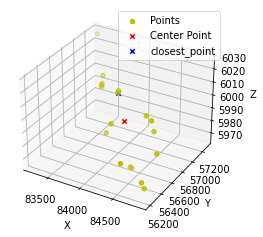

In [146]:

## Testing function with some manually inserted dots
import numpy as np
import matplotlib.pyplot as plt

# Example XYZ coordinates
points = [
    [66659, 85714, 5406],
    [66885, 85749, 5367],
    [67124, 86454, 5390],
    [67664, 86251, 5434],
    [67273, 85576, 5497],
    [66399, 85482, 5428],
    [66803, 85360, 5477],
    [66505, 85552, 5413],
    [66772, 85838, 5450],
    [66496, 85540, 5402],
    [72452, 82402, 5694],
    [75373, 80809, 5808]
]

points = neurons_inputs_LO['post_pt_position'].tolist()

# Convert the points to a NumPy array
points = np.array(points)

# Set the threshold distance to exclude outliers
threshold = 5000

# Find the center point
center_point, closest_point  = find_center_point(points, threshold)

if center_point is not None:
    print("Center Point:", center_point)
else:
    print("No valid points within the threshold.")

# Plotting the points and center point
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for the points
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='y', label='Points')

# Scatter plot for the center point
if center_point is not None:
    ax.scatter(center_point[0], center_point[1], center_point[2], c='r', marker='x', label='Center Point')
    ax.scatter(closest_point [0], closest_point [1], closest_point [2], c='b', marker='x', label='closest_point')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

plt.show()

### 4. Saving back to excel file

In [32]:

# Creating string for the date
import datetime
x = datetime.datetime.now()
date_str = x.strftime("%d") + x.strftime("%b") + x.strftime("%Y")

# Writting in an existing excel file
from openpyxl import load_workbook
book = load_workbook(filePath)
writer = pd.ExcelWriter(filePath, engine = 'openpyxl')
writer.book = book

df.to_excel(writer, sheet_name='Updated_table_'+date_str) #sorted_df
writer.save()
writer.close()

# C) Updating of list of IDs from a txt file


### 1. Loading the data from a txt file

In [8]:
# Choose path and file
import os

dataPath = r'E:\Connectomics-Data\FlyWire\Txts\cell_type_proofread'
fileDate = '20230614'
fileName = f'root_ids_Mi4_side_right.txt'
filePath = os.path.join(dataPath,fileName)
ids_df = pd.read_csv(filePath, sep = ",")
curr_ID_ls = ids_df.columns.tolist()

In [9]:
#Updating the IDs via Fafbseg
updated_ID_df = fafbseg.flywire.update_ids(curr_ID_ls, stop_layer=2, supervoxels=None, timestamp=None, dataset='production', progress=True)

Updating:   0%|          | 0/735 [00:00<?, ?it/s]

In [10]:
display(updated_ID_df.head())
print('Update confidences: ')
print(set(updated_ID_df['confidence'].tolist()))

,old_id,new_id,confidence,changed
0,720575940626552834,720575940626552834,1.0,False
1,720575940627054595,720575940627054595,1.0,False
2,720575940606935051,720575940628813800,1.0,True
3,720575940620570641,720575940620570641,1.0,False
4,720575940631523346,720575940631523346,1.0,False


Update confidences: 
{0.73, 1.0, 0.91, 0.99, 0.98, 0.93, 0.48, 0.9, 0.94, 0.96, 0.55}


In [11]:
updated_ID_df[updated_ID_df['confidence'] < 0.98]

,old_id,new_id,confidence,changed
32,720575940631431272,720575940640365629,0.73,True
40,720575940640555136,720575940623426525,0.91,True
102,720575940626147621,720575940630625474,0.93,True
146,720575940623679880,720575940630731898,0.48,True
233,720575940610890360,720575940631604055,0.90,True
346,720575940644209608,720575940624864437,0.94,True
461,720575940641660149,720575940623892685,0.94,True
480,720575940622318881,720575940628575765,0.96,True
501,720575940636947824,720575940661041025,0.55,True
711,720575940634265524,720575940631021372,0.96,True


In [12]:
#Saving the data
updated_fileName = f'Updated_{fileName}'
updated_filePath = os.path.join(dataPath,updated_fileName)

id_list = updated_ID_df['new_id'].tolist()
with open(updated_filePath , "w") as output:
    output.write(str(id_list))


In [13]:
updated_filePath

'E:\\Connectomics-Data\\FlyWire\\Txts\\cell_type_proofread\\Updated_root_ids_Mi4_side_right.txt'